# Resistor Ladder

Before running complex transient analyses, it is standard practice to validate the solver against a known analytical solution. For this purpose, we use the R-2R Ladder Network.This circuit acts as a precise voltage divider. We have configured a "1-2-1" ladder where:

Series Resistors ($R_S$) = $1000\Omega$ ($R$)
Shunt/Termination Resistors ($R_P$) = $2000\Omega$ ($2R$)T

The Analytical Benchmark: Due to the recursive nature of the equivalent resistance in an R-2R ladder, the voltage at each successive node should be exactly half of the previous node.

* Node 1: $4.0V$
* Node 2: $2.0V$
* Node 3: $1.0V$

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from circulus.components.electronic import Resistor, VoltageSource
from circulus.compiler import compile_netlist
from circulus.solvers import analyze_circuit
import time

In [2]:
net_dict = {
    "instances": {
        "GND": {"component": "ground"},
        "V_REF": {"component": "source_voltage", "settings": {"V": 8.0}},
        "R_S1": {"component": "resistor", "settings": {"R": 1000.0}},
        "R_P1": {"component": "resistor", "settings": {"R": 2000.0}},
        "R_S2": {"component": "resistor", "settings": {"R": 1000.0}},
        "R_P2": {"component": "resistor", "settings": {"R": 2000.0}},
        "R_S3": {"component": "resistor", "settings": {"R": 1000.0}},
        "R_P3": {"component": "resistor", "settings": {"R": 2000.0}},
        "R_TERM": {"component": "resistor", "settings": {"R": 2000.0}},
    },
    "connections": {
        "GND,p1": ("V_REF,p2", "R_P1,p2", "R_P2,p2", "R_P3,p2", "R_TERM,p2"),
        "V_REF,p1": "R_S1,p1",
        "R_S1,p2": ("R_P1,p1", "R_S2,p1"),
        "R_S2,p2": ("R_P2,p1", "R_S3,p1"),
        "R_S3,p2": ("R_P3,p1", "R_TERM,p1"),
    },
}

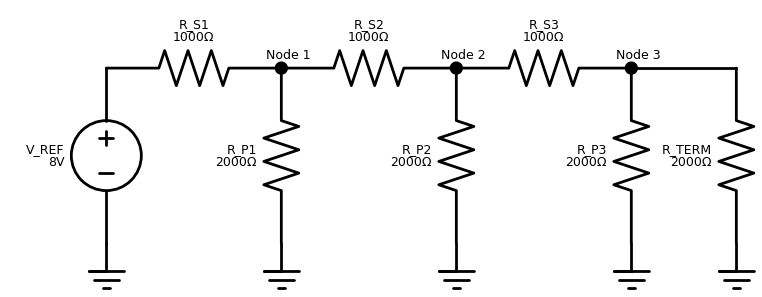

In [ ]:
import schemdraw
import schemdraw.elements as elm


# Helper to format labels
def get_label(name, val_key, unit):
    try:
        val = net_dict["instances"][name]["settings"][val_key]
        return f"{name}\n{val:.0f}{unit}"
    except KeyError:
        return name


with schemdraw.Drawing() as d:
    d.config(fontsize=9, unit=2.5, inches_per_unit=0.7)

    # 1. Reference Voltage
    # Start ground at (0,0)
    d.add(elm.Ground())
    v_ref = d.add(elm.SourceV().up().label(get_label("V_REF", "V", "V")))

    # Save the top rail starting point
    current_node = v_ref.end

    # 2. Draw the Stages (R_S followed by R_P)
    # We have 3 stages: (S1, P1), (S2, P2), (S3, P3)
    stages = [
        ("R_S1", "R_P1", "Node 1"),
        ("R_S2", "R_P2", "Node 2"),
        ("R_S3", "R_P3", "Node 3"),
    ]

    for i, (rs_name, rp_name, node_label) in enumerate(stages):
        # Draw Series Resistor (Horizontal)
        rs = d.add(
            elm.Resistor().right().at(current_node).label(get_label(rs_name, "R", "Ω"))
        )

        # Save this junction point
        current_node = rs.end

        # Add a dot and the Node Label
        d.add(elm.Dot().at(current_node))
        d.add(elm.Label().label(node_label, loc="top").at(current_node))

        # Draw Shunt Resistor (Vertical to Ground)
        d.add(
            elm.Resistor().down().at(current_node).label(get_label(rp_name, "R", "Ω"))
        )
        d.add(elm.Ground())

    # 3. Termination Resistor
    # In your netlist, R_TERM is parallel to R_P3 (connected to Node 3)
    # To visualize this cleanly, we can draw it parallel to R_P3
    # Go right a bit from Node 3, then down

    d.add(elm.Line().right().length(1.5).at(current_node))
    d.add(elm.Resistor().down().label(get_label("R_TERM", "R", "Ω")))
    d.add(elm.Ground())

1. Compiling Circuit...
   System Size: 6 variables

2. Solving DC Operating Point...
Time take = 0.1424s

3. Verification:
   V_REF:    8.0 V
   Node 1:   4.0000 V  (Expected: 4.0000 V)
   Node 2:   2.0000 V  (Expected: 2.0000 V)
   Node 3:   1.0000 V  (Expected: 1.0000 V)
   Ground:   -4.4e-25 V  (Expected: 0.0)


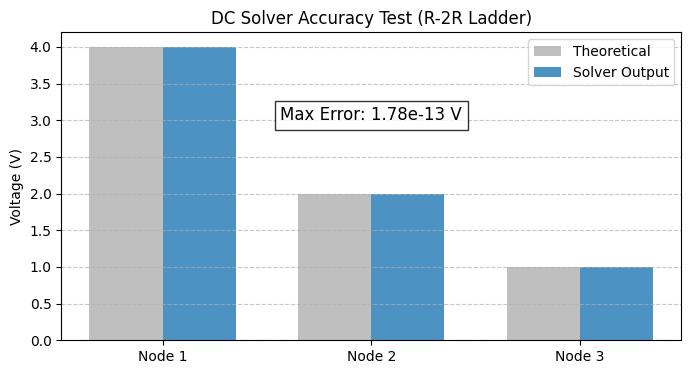


✅ DC Solver PASSED


In [ ]:
jax.config.update("jax_enable_x64", True)

models_map = {
    "resistor": Resistor,
    "source_voltage": VoltageSource,
    "ground": lambda: 0,
}


print("1. Compiling Circuit...")
groups, num_vars, port_map = compile_netlist(net_dict, models_map)
print(f"   System Size: {num_vars} variables")

linear_strategy = analyze_circuit(groups, num_vars)

print("\n2. Solving DC Operating Point...")

y_guess = jnp.zeros(num_vars)

start = time.time()
y_dc = linear_strategy.solve_dc(component_groups=groups, y_guess=y_guess)
print(f"Time take = {time.time() - start:.4f}s")

print("\n3. Verification:")


def get_v(name):
    idx = port_map[name]
    return float(y_dc[idx])


v_n1 = get_v("R_S1,p2")
v_n2 = get_v("R_S2,p2")
v_n3 = get_v("R_S3,p2")

print("   V_REF:    8.0 V")
print(f"   Node 1:   {v_n1:.4f} V  (Expected: 4.0000 V)")
print(f"   Node 2:   {v_n2:.4f} V  (Expected: 2.0000 V)")
print(f"   Node 3:   {v_n3:.4f} V  (Expected: 1.0000 V)")

v_gnd = get_v("R_TERM,p2")
print(f"   Ground:   {v_gnd:.1e} V  (Expected: 0.0)")

nodes = ["Node 1", "Node 2", "Node 3"]
voltages = [v_n1, v_n2, v_n3]
expected = [4.0, 2.0, 1.0]

plt.figure(figsize=(8, 4))
x = np.arange(len(nodes))
width = 0.35

plt.bar(x - width / 2, expected, width, label="Theoretical", color="gray", alpha=0.5)
plt.bar(
    x + width / 2, voltages, width, label="Solver Output", color="tab:blue", alpha=0.8
)

plt.ylabel("Voltage (V)")
plt.title("DC Solver Accuracy Test (R-2R Ladder)")
plt.xticks(x, nodes)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

max_err = np.max(np.abs(np.array(voltages) - np.array(expected)))
plt.text(
    1,
    3,
    f"Max Error: {max_err:.2e} V",
    ha="center",
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.8),
)

plt.show()

if max_err < 1e-6:
    print("\n✅ DC Solver PASSED")
else:
    print("\n❌ DC Solver FAILED")